Quickstart
======

Here is a small example on how to do Bayesian model selection.

Step by step explanation
----------------------------

### Defining a model


To do model selection, we first need some models. A model, in the simplest case,
is just a callable which takes a single `dict` as input and returns a single `dict` as output. The keys of the input dictionary are the parameters of the model, the output
keys denote the summary statistics.
Here, the `dict` is passed as `parameters` and has the entry `x`, which denotes the mean of a Gaussian.
It returns the observed summary statistics `y`, which is just the sampled value.

In [1]:
%matplotlib inline
import os
import tempfile
import numpy as np

import scipy.stats as st

from pyabc import (ABCSMC, RV, Distribution,
                   PercentileDistanceFunction)

In [2]:
import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel

In [3]:
sample_size = 5
ntest = 10

k2 = 2.
theta2 = 1.0

k3 = 2.
theta3 = 2. 

# then the scale of the Gamma prior for the Poisson is given by
theta1 = 2.0
k1 = (k2 * theta2 * k3 * theta3) / theta1
print(k1)

4.0


In [4]:
%matplotlib inline
import os
import tempfile

import scipy.stats as st

from pyabc import (ABCSMC, RV, Distribution, 
                   PercentileDistanceFunction, sampler)

# Define a gaussian model
sigma = 1.


def Poisson_model(parameters):
    x = scipy.stats.poisson.rvs(parameters.lam, size=sample_size)
    return {'y1': x.mean(), 'y2': x.var()}

def NB_model(parameters): 
    lams = scipy.stats.gamma.rvs(a=parameters.k, scale=parameters.theta, size=sample_size)
    x = scipy.stats.poisson.rvs(lams)
    return {'y1': x.mean(), 'y2': x.var()}

For model selection we usually have more than one model.
These are assembled in a list. We
require a Bayesian prior over the models.
The default is to have a uniform prior over the model classes.
This concludes the model definition.

In [5]:
# We define two models, but they are identical so far
models = [Poisson_model, NB_model]


# Define priors 
prior1 = Distribution.from_dictionary_of_dictionaries(dict(lam={'type': 'gamma', 'kwargs': {'a':k1, 'scale': theta1}}))

prior2 = Distribution.from_dictionary_of_dictionaries(dict(k={'type': 'gamma', 'kwargs': {'a':k2, 'scale': theta2}}, 
                                                     theta={'type': 'gamma', 'kwargs': {'a':k3, 'scale': theta3}}))

parameter_priors = [prior1, prior2]

### Configuring the ABCSMC run

Having the models defined, we can plug together the `ABCSMC` class.
We need a distance function,
to measure the distance of obtained samples.

In [6]:
# We plug all the ABC options together
abc = ABCSMC(
    models, parameter_priors,
    PercentileDistanceFunction(measures_to_use=["y1", "y2"]))

### Setting the observed data

Actually measured data can now be passed to the ABCSMC.
This is set via the `new` method, indicating that we start
a new run as opposed to resuming a stored run (see the "resume stored run" example).
Moreover, we have to set the output database where the ABC-SMC run
is logged.

## Load test data for comparison to DE

In [30]:
import pickle 

fn = '../data/201812141735__poisson_posterior_trained_N50000M5_k2.p'
dd = pickle.load( open( fn, "rb" ) )['d_model_post']

In [31]:
sx_t = dd['sx_test'][:200]

## Run a loop over all test data points

In [32]:
n_simulations = np.zeros(sx_t.shape[0])
phat = np.zeros((2, sx_t.shape[0]))

for idx, y_observed in enumerate(sx_t): 
    # y_observed is the important piece here: our actual observation.
    # and we define where to store the results
    db_path = ("sqlite:///" +
               os.path.join(tempfile.gettempdir(), "test.db"))
    abc_id = abc.new(db_path, {"y1": y_observed[0], "y2": y_observed[1]})

    # We run the ABC until either criterion is met
    history = abc.run(minimum_epsilon=0.00001, max_nr_populations=10)
    
    n_simulations[idx] = history.total_nr_simulations
    
    phat[:, idx] = history.get_model_probabilities().values[-1, :]

INFO:History:Start <ABCSMC(id=757, start_time=2018-12-16 17:23:08.294957, end_time=None)>
INFO:Epsilon:initial epsilon is 3.1417283746328555
INFO:ABC:t:0 eps:3.1417283746328555
INFO:ABC:t:1 eps:2.4766383062829513
INFO:ABC:t:2 eps:1.7467855924209292
INFO:ABC:t:3 eps:1.1900161441678103
INFO:ABC:t:4 eps:0.7882446080621257
INFO:ABC:t:5 eps:0.529659425764949
INFO:ABC:t:6 eps:0.3500617676772276
INFO:ABC:t:7 eps:0.24811888378677777
INFO:ABC:t:8 eps:0.17668259944592707
INFO:ABC:t:9 eps:0.10978732010461606
INFO:History:Done <ABCSMC(id=757, start_time=2018-12-16 17:23:08.294957, end_time=2018-12-16 17:23:23.598585)>
INFO:History:Start <ABCSMC(id=758, start_time=2018-12-16 17:23:23.633958, end_time=None)>
INFO:Epsilon:initial epsilon is 1.3588048189669835
INFO:ABC:t:0 eps:1.3588048189669835
INFO:ABC:t:1 eps:1.1139609389723153
INFO:ABC:t:2 eps:0.8510918544633618
INFO:ABC:t:3 eps:0.6064148121873489
INFO:ABC:t:4 eps:0.4764728324071394
INFO:ABC:t:5 eps:0.33477237597710197
INFO:ABC:t:6 eps:0.215894618

INFO:ABC:t:2 eps:0.6129936196967004
INFO:ABC:t:3 eps:0.5003652316317238
INFO:ABC:t:4 eps:0.3695531585776797
INFO:ABC:t:5 eps:0.24300837914511048
INFO:ABC:t:6 eps:0.16834668615581205
INFO:ABC:t:7 eps:0.1383315636821615
INFO:ABC:t:8 eps:0.0962506377638966
INFO:ABC:t:9 eps:0.07209604839191563
INFO:History:Done <ABCSMC(id=770, start_time=2018-12-16 17:25:59.900266, end_time=2018-12-16 17:26:17.369005)>
INFO:History:Start <ABCSMC(id=771, start_time=2018-12-16 17:26:17.488176, end_time=None)>
INFO:Epsilon:initial epsilon is 1.2532232932059186
INFO:ABC:t:0 eps:1.2532232932059186
INFO:ABC:t:1 eps:0.8958686689005643
INFO:ABC:t:2 eps:0.6798294717910432
INFO:ABC:t:3 eps:0.4759258922208696
INFO:ABC:t:4 eps:0.35618941891666894
INFO:ABC:t:5 eps:0.2503154884024582
INFO:ABC:t:6 eps:0.18298652766861104
INFO:ABC:t:7 eps:0.12077294685990336
INFO:ABC:t:8 eps:0.08197851597512376
INFO:ABC:t:9 eps:0.0574562068791169
INFO:History:Done <ABCSMC(id=771, start_time=2018-12-16 17:26:17.488176, end_time=2018-12-16 

INFO:ABC:t:9 eps:0.04757373929590871
INFO:History:Done <ABCSMC(id=783, start_time=2018-12-16 17:28:53.103521, end_time=2018-12-16 17:29:07.887180)>
INFO:History:Start <ABCSMC(id=784, start_time=2018-12-16 17:29:07.924365, end_time=None)>
INFO:Epsilon:initial epsilon is 1.2567396130669195
INFO:ABC:t:0 eps:1.2567396130669195
INFO:ABC:t:1 eps:0.5970734106464043
INFO:ABC:t:2 eps:0.19493596970483834
INFO:ABC:t:3 eps:0.05269883294952589
INFO:ABC:t:4 eps:0.028911963301571544
INFO:ABC:t:5 eps:0.028911963301571544
INFO:ABC:t:6 eps:1.6505456479322623e-18
INFO:History:Done <ABCSMC(id=784, start_time=2018-12-16 17:29:07.924365, end_time=2018-12-16 17:29:12.859728)>
INFO:History:Start <ABCSMC(id=785, start_time=2018-12-16 17:29:12.897917, end_time=None)>
INFO:Epsilon:initial epsilon is 0.7505963954274043
INFO:ABC:t:0 eps:0.7505963954274043
INFO:ABC:t:1 eps:0.3861057102276644
INFO:ABC:t:2 eps:0.23957274925388827
INFO:ABC:t:3 eps:0.16575327549809674
INFO:ABC:t:4 eps:0.09545163655180429
INFO:ABC:t:5 e

INFO:ABC:t:5 eps:1.9270887806329748
INFO:ABC:t:6 eps:1.2912903661272848
INFO:ABC:t:7 eps:0.8240708455479618
INFO:ABC:t:8 eps:0.572892579307538
INFO:ABC:t:9 eps:0.3959636892824098
INFO:History:Done <ABCSMC(id=797, start_time=2018-12-16 17:31:23.832152, end_time=2018-12-16 17:31:36.925022)>
INFO:History:Start <ABCSMC(id=798, start_time=2018-12-16 17:31:36.960562, end_time=None)>
INFO:Epsilon:initial epsilon is 2.645513589542048
INFO:ABC:t:0 eps:2.645513589542048
INFO:ABC:t:1 eps:1.9580730567161706
INFO:ABC:t:2 eps:1.4065128265325701
INFO:ABC:t:3 eps:0.9343851487353227
INFO:ABC:t:4 eps:0.6708295709265719
INFO:ABC:t:5 eps:0.5062654618036578
INFO:ABC:t:6 eps:0.3430975461150606
INFO:ABC:t:7 eps:0.24393903221990226
INFO:ABC:t:8 eps:0.1724415190221801
INFO:ABC:t:9 eps:0.08124307652707062
INFO:History:Done <ABCSMC(id=798, start_time=2018-12-16 17:31:36.960562, end_time=2018-12-16 17:32:16.244021)>
INFO:History:Start <ABCSMC(id=799, start_time=2018-12-16 17:32:16.282671, end_time=None)>
INFO:Eps

INFO:History:Start <ABCSMC(id=811, start_time=2018-12-16 17:35:14.347964, end_time=None)>
INFO:Epsilon:initial epsilon is 0.707239941716423
INFO:ABC:t:0 eps:0.707239941716423
INFO:ABC:t:1 eps:0.43001374352468535
INFO:ABC:t:2 eps:0.28752928903455716
INFO:ABC:t:3 eps:0.1913981163557136
INFO:ABC:t:4 eps:0.12049022136553514
INFO:ABC:t:5 eps:0.09112554411027907
INFO:ABC:t:6 eps:0.07136060894386308
INFO:ABC:t:7 eps:0.052096710785861686
INFO:ABC:t:8 eps:0.028911963301571617
INFO:ABC:t:9 eps:0.023786869647954303
INFO:History:Done <ABCSMC(id=811, start_time=2018-12-16 17:35:14.347964, end_time=2018-12-16 17:35:33.758316)>
INFO:History:Start <ABCSMC(id=812, start_time=2018-12-16 17:35:33.794412, end_time=None)>
INFO:Epsilon:initial epsilon is 1.14236728765335
INFO:ABC:t:0 eps:1.14236728765335
INFO:ABC:t:1 eps:0.8031343509976693
INFO:ABC:t:2 eps:0.5477663690897899
INFO:ABC:t:3 eps:0.413529177451545
INFO:ABC:t:4 eps:0.30100239478730745
INFO:ABC:t:5 eps:0.22704486290602552
INFO:ABC:t:6 eps:0.148214

INFO:ABC:t:1 eps:0.7068722219923973
INFO:ABC:t:2 eps:0.30100322458154344
INFO:ABC:t:3 eps:0.10576538562307809
INFO:ABC:t:4 eps:0.047941459019935
INFO:ABC:t:5 eps:0.02415458937198067
INFO:ABC:t:6 eps:0.02378686964795434
INFO:ABC:t:7 eps:0.0
INFO:History:Done <ABCSMC(id=824, start_time=2018-12-16 17:38:14.504075, end_time=2018-12-16 17:38:20.730812)>
INFO:History:Start <ABCSMC(id=825, start_time=2018-12-16 17:38:20.768505, end_time=None)>
INFO:Epsilon:initial epsilon is 0.7505963954274043
INFO:ABC:t:0 eps:0.7505963954274043
INFO:ABC:t:1 eps:0.3714658687148655
INFO:ABC:t:2 eps:0.2492824819277747
INFO:ABC:t:3 eps:0.17351465061342067
INFO:ABC:t:4 eps:0.10161499578939907
INFO:ABC:t:5 eps:0.0673386744623248
INFO:ABC:t:6 eps:0.04757373929590869
INFO:ABC:t:7 eps:0.03366933723116242
INFO:ABC:t:8 eps:0.02378686964795433
INFO:ABC:t:9 eps:0.0
INFO:History:Done <ABCSMC(id=825, start_time=2018-12-16 17:38:20.768505, end_time=2018-12-16 17:38:33.860129)>
INFO:History:Start <ABCSMC(id=826, start_time=2

INFO:History:Start <ABCSMC(id=838, start_time=2018-12-16 17:41:48.832741, end_time=None)>
INFO:Epsilon:initial epsilon is 0.9775024476344121
INFO:ABC:t:0 eps:0.9775024476344121
INFO:ABC:t:1 eps:0.3838993918835059
INFO:ABC:t:2 eps:0.2056968522766159
INFO:ABC:t:3 eps:0.13263642043760973
INFO:ABC:t:4 eps:0.08636817018068826
INFO:ABC:t:5 eps:0.05782392660314307
INFO:ABC:t:6 eps:0.05745620687911676
INFO:ABC:t:7 eps:0.03366933723116242
INFO:ABC:t:8 eps:0.02378686964795433
INFO:ABC:t:9 eps:0.0
INFO:History:Done <ABCSMC(id=838, start_time=2018-12-16 17:41:48.832741, end_time=2018-12-16 17:41:59.259682)>
INFO:History:Start <ABCSMC(id=839, start_time=2018-12-16 17:41:59.295415, end_time=None)>
INFO:Epsilon:initial epsilon is 9.332738087030066
INFO:ABC:t:0 eps:9.332738087030066
INFO:ABC:t:1 eps:8.54225559278718
INFO:ABC:t:2 eps:7.512719123217478
INFO:ABC:t:3 eps:6.103638795929242
INFO:ABC:t:4 eps:4.469803483241103
INFO:ABC:t:5 eps:2.6073505917375908
INFO:ABC:t:6 eps:1.6142614940076847
INFO:ABC:t:

INFO:ABC:t:3 eps:0.22768563332480835
INFO:ABC:t:4 eps:0.1299199749950588
INFO:ABC:t:5 eps:0.1050299461750253
INFO:ABC:t:6 eps:0.08161079625109749
INFO:ABC:t:7 eps:0.05782392660314313
INFO:ABC:t:8 eps:0.0384267111607532
INFO:ABC:t:9 eps:0.03366933723116228
INFO:History:Done <ABCSMC(id=851, start_time=2018-12-16 17:45:00.298244, end_time=2018-12-16 17:45:15.344679)>
INFO:History:Start <ABCSMC(id=852, start_time=2018-12-16 17:45:15.381238, end_time=None)>
INFO:Epsilon:initial epsilon is 1.4021957464020922
INFO:ABC:t:0 eps:1.4021957464020922
INFO:ABC:t:1 eps:1.0047711634192416
INFO:ABC:t:2 eps:0.7458505127391903
INFO:ABC:t:3 eps:0.4917927281452854
INFO:ABC:t:4 eps:0.3156049530201973
INFO:ABC:t:5 eps:0.21629565439893259
INFO:ABC:t:6 eps:0.16610745175764902
INFO:ABC:t:7 eps:0.11206786295783815
INFO:ABC:t:8 eps:0.07666363909708267
INFO:ABC:t:9 eps:0.052698832949526084
INFO:History:Done <ABCSMC(id=852, start_time=2018-12-16 17:45:15.381238, end_time=2018-12-16 17:45:28.827206)>
INFO:History:St

INFO:ABC:t:8 eps:0.043184085090344285
INFO:ABC:t:9 eps:0.028911963301571565
INFO:History:Done <ABCSMC(id=864, start_time=2018-12-16 17:48:31.113032, end_time=2018-12-16 17:48:57.225710)>
INFO:History:Start <ABCSMC(id=865, start_time=2018-12-16 17:48:57.263230, end_time=None)>
INFO:Epsilon:initial epsilon is 0.7050451146136403
INFO:ABC:t:0 eps:0.7050451146136403
INFO:ABC:t:1 eps:0.41829267732134545
INFO:ABC:t:2 eps:0.2737623086251092
INFO:ABC:t:3 eps:0.17822915373902015
INFO:ABC:t:4 eps:0.11015503982864266
INFO:ABC:t:5 eps:0.08600045045666196
INFO:ABC:t:6 eps:0.062581300532734
INFO:ABC:t:7 eps:0.03842671116075336
INFO:ABC:t:8 eps:0.023786869647954356
INFO:ABC:t:9 eps:0.023786869647954303
INFO:History:Done <ABCSMC(id=865, start_time=2018-12-16 17:48:57.263230, end_time=2018-12-16 17:49:18.544440)>
INFO:History:Start <ABCSMC(id=866, start_time=2018-12-16 17:49:18.581108, end_time=None)>
INFO:Epsilon:initial epsilon is 1.4419324590796887
INFO:ABC:t:0 eps:1.4419324590796887
INFO:ABC:t:1 eps

INFO:History:Start <ABCSMC(id=878, start_time=2018-12-16 17:52:21.416985, end_time=None)>
INFO:Epsilon:initial epsilon is 0.72680952577945
INFO:ABC:t:0 eps:0.72680952577945
INFO:ABC:t:1 eps:0.3590208543048487
INFO:ABC:t:2 eps:0.2170235846237997
INFO:ABC:t:3 eps:0.1445598165078577
INFO:ABC:t:4 eps:0.09604984120852327
INFO:ABC:t:5 eps:0.07193933523885664
INFO:ABC:t:6 eps:0.038791012118216006
INFO:ABC:t:7 eps:0.028911963301571485
INFO:ABC:t:8 eps:0.02378686964795433
INFO:ABC:t:9 eps:0.02378686964795433
INFO:History:Done <ABCSMC(id=878, start_time=2018-12-16 17:52:21.416985, end_time=2018-12-16 17:52:33.907450)>
INFO:History:Start <ABCSMC(id=879, start_time=2018-12-16 17:52:33.946170, end_time=None)>
INFO:Epsilon:initial epsilon is 0.7324747077777313
INFO:ABC:t:0 eps:0.7324747077777313
INFO:ABC:t:1 eps:0.45213438317314547
INFO:ABC:t:2 eps:0.3107747421608096
INFO:ABC:t:3 eps:0.2247215718397242
INFO:ABC:t:4 eps:0.16832901311570223
INFO:ABC:t:5 eps:0.1251435820757025
INFO:ABC:t:6 eps:0.096978

INFO:ABC:t:3 eps:0.8835264459029379
INFO:ABC:t:4 eps:0.5857982105747805
INFO:ABC:t:5 eps:0.3827848416998448
INFO:ABC:t:6 eps:0.2437237932849985
INFO:ABC:t:7 eps:0.1774937142909676
INFO:ABC:t:8 eps:0.13030741917806246
INFO:ABC:t:9 eps:0.09588291803987009
INFO:History:Done <ABCSMC(id=891, start_time=2018-12-16 17:55:35.433621, end_time=2018-12-16 17:55:50.208695)>
INFO:History:Start <ABCSMC(id=892, start_time=2018-12-16 17:55:50.246337, end_time=None)>
INFO:Epsilon:initial epsilon is 0.7123650353700408
INFO:ABC:t:0 eps:0.7123650353700408
INFO:ABC:t:1 eps:0.3732814848522456
INFO:ABC:t:2 eps:0.2315718834599914
INFO:ABC:t:3 eps:0.15661985402868894
INFO:ABC:t:4 eps:0.10978732010461628
INFO:ABC:t:5 eps:0.08600045045666196
INFO:ABC:t:6 eps:0.05782392660314313
INFO:ABC:t:7 eps:0.03842671116075331
INFO:ABC:t:8 eps:0.03366933723116244
INFO:ABC:t:9 eps:0.03366933723116244
INFO:History:Done <ABCSMC(id=892, start_time=2018-12-16 17:55:50.246337, end_time=2018-12-16 17:56:07.504516)>
INFO:History:Sta

INFO:History:Done <ABCSMC(id=904, start_time=2018-12-16 17:58:40.806905, end_time=2018-12-16 17:58:59.348157)>
INFO:History:Start <ABCSMC(id=905, start_time=2018-12-16 17:58:59.385841, end_time=None)>
INFO:Epsilon:initial epsilon is 3.6558235313044394
INFO:ABC:t:0 eps:3.6558235313044394
INFO:ABC:t:1 eps:3.028723506943008
INFO:ABC:t:2 eps:2.3780396907756094
INFO:ABC:t:3 eps:1.9073701845686077
INFO:ABC:t:4 eps:1.5026231355536364
INFO:ABC:t:5 eps:1.261871553287608
INFO:ABC:t:6 eps:1.0244046574689412
INFO:ABC:t:7 eps:0.7529019406085758
INFO:ABC:t:8 eps:0.5185381163437294
INFO:ABC:t:9 eps:0.3380542686321961
INFO:History:Done <ABCSMC(id=905, start_time=2018-12-16 17:58:59.385841, end_time=2018-12-16 17:59:08.182990)>
INFO:History:Start <ABCSMC(id=906, start_time=2018-12-16 17:59:08.222612, end_time=None)>
INFO:Epsilon:initial epsilon is 0.7187426743336222
INFO:ABC:t:0 eps:0.7187426743336222
INFO:ABC:t:1 eps:0.4591095666882702
INFO:ABC:t:2 eps:0.29645591786807224
INFO:ABC:t:3 eps:0.1954200508

INFO:ABC:t:2 eps:2.926773630659432
INFO:ABC:t:3 eps:2.1786326348913483
INFO:ABC:t:4 eps:1.5496287793706878
INFO:ABC:t:5 eps:1.128357619109084
INFO:ABC:t:6 eps:0.8827929450830054
INFO:ABC:t:7 eps:0.6547249686289112
INFO:ABC:t:8 eps:0.48154634974718463
INFO:ABC:t:9 eps:0.3856734403448221
INFO:History:Done <ABCSMC(id=918, start_time=2018-12-16 18:02:16.118978, end_time=2018-12-16 18:02:27.251103)>
INFO:History:Start <ABCSMC(id=919, start_time=2018-12-16 18:02:27.293431, end_time=None)>
INFO:Epsilon:initial epsilon is 0.7956075878965054
INFO:ABC:t:0 eps:0.7956075878965054
INFO:ABC:t:1 eps:0.4794145901993501
INFO:ABC:t:2 eps:0.35682920724142464
INFO:ABC:t:3 eps:0.2695437367245554
INFO:ABC:t:4 eps:0.20750883676461795
INFO:ABC:t:5 eps:0.14437077891807645
INFO:ABC:t:6 eps:0.09623858397469662
INFO:ABC:t:7 eps:0.07742495242972831
INFO:ABC:t:8 eps:0.05782392660314313
INFO:ABC:t:9 eps:0.04757373929590866
INFO:History:Done <ABCSMC(id=919, start_time=2018-12-16 18:02:27.293431, end_time=2018-12-16 1

INFO:History:Done <ABCSMC(id=931, start_time=2018-12-16 18:05:20.770617, end_time=2018-12-16 18:05:41.528714)>
INFO:History:Start <ABCSMC(id=932, start_time=2018-12-16 18:05:41.566557, end_time=None)>
INFO:Epsilon:initial epsilon is 0.834608861126049
INFO:ABC:t:0 eps:0.834608861126049
INFO:ABC:t:1 eps:0.5050400584674362
INFO:ABC:t:2 eps:0.32246631741481924
INFO:ABC:t:3 eps:0.21592042545172074
INFO:ABC:t:4 eps:0.15772877912455133
INFO:ABC:t:5 eps:0.1010080116934872
INFO:ABC:t:6 eps:0.0772211420455329
INFO:ABC:t:7 eps:0.05421305176665941
INFO:ABC:t:8 eps:0.04318408509034423
INFO:ABC:t:9 eps:0.02397528907393865
INFO:History:Done <ABCSMC(id=932, start_time=2018-12-16 18:05:41.566557, end_time=2018-12-16 18:05:59.510001)>
INFO:History:Start <ABCSMC(id=933, start_time=2018-12-16 18:05:59.547678, end_time=None)>
INFO:Epsilon:initial epsilon is 0.9484181157122034
INFO:ABC:t:0 eps:0.9484181157122034
INFO:ABC:t:1 eps:0.6486920669066031
INFO:ABC:t:2 eps:0.45361684919879636
INFO:ABC:t:3 eps:0.3049

INFO:ABC:t:0 eps:0.720225044471104
INFO:ABC:t:1 eps:0.3879213263650442
INFO:ABC:t:2 eps:0.25642128477704684
INFO:ABC:t:3 eps:0.1859303135604772
INFO:ABC:t:4 eps:0.13457727457078128
INFO:ABC:t:5 eps:0.09625063776389622
INFO:ABC:t:6 eps:0.06697095473829838
INFO:ABC:t:7 eps:0.04318408509034402
INFO:ABC:t:8 eps:0.02378686964795441
INFO:ABC:t:9 eps:0.02378686964795425
INFO:History:Done <ABCSMC(id=945, start_time=2018-12-16 18:08:52.602892, end_time=2018-12-16 18:09:10.562773)>
INFO:History:Start <ABCSMC(id=946, start_time=2018-12-16 18:09:10.601006, end_time=None)>
INFO:Epsilon:initial epsilon is 3.6575931824763166
INFO:ABC:t:0 eps:3.6575931824763166
INFO:ABC:t:1 eps:2.9390343680047066
INFO:ABC:t:2 eps:2.2672878317039333
INFO:ABC:t:3 eps:1.7567290757452936
INFO:ABC:t:4 eps:1.3316695786458366
INFO:ABC:t:5 eps:0.9403482833519671
INFO:ABC:t:6 eps:0.756251238784471
INFO:ABC:t:7 eps:0.586875090585459
INFO:ABC:t:8 eps:0.37056210540860507
INFO:ABC:t:9 eps:0.2488915535563642
INFO:History:Done <ABCS

## Calculate true posterior 

In [33]:
ptrue = np.array(dd['ppoi_exact'][:sx_t.shape[0]])
ptrue = np.vstack((ptrue, 1 - ptrue))

In [34]:
n_simulations.mean()

51470.175

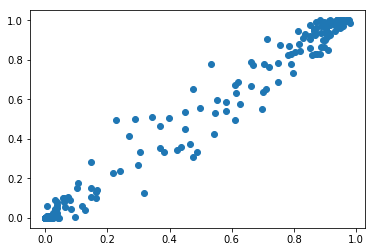

In [35]:
plt.plot(ptrue[0, :], phat[0, :], 'o')

In [36]:
np.abs(phat[0, :] - ptrue[0, :]).mean()

0.04840694053636519

In [37]:
dd = dict(phat=phat, nsims=n_simulations, ptrue=ptrue)

In [38]:
import time
time_stamp = time.strftime('%Y%m%d%H%M_')
fn = os.path.join('../data/', time_stamp + '_SMCABC_results_PoissonNB_Ntest{}.p'.format(sx_t.shape[0]))

with open(fn, 'wb') as outfile: 
    pickle.dump(dd, outfile, protocol=pickle.HIGHEST_PROTOCOL)